# Lab14-2 GAN
110065508 李丞恩

In [1]:
SAMPLE_COL = 16
SAMPLE_ROW = 16
SAMPLE_NUM = SAMPLE_COL * SAMPLE_ROW

IMG_H = 64
IMG_W = 64
IMG_C = 3
IMG_SHAPE = (IMG_H, IMG_W, IMG_C)

BATCH_SIZE = 5000
Z_DIM = 128
BZ = (BATCH_SIZE, Z_DIM)
BUF = 65536

DC_LR = 2.5e-04
DC_EPOCH = 256

W_LR = 2.0e-04
W_EPOCH = 256
WClipLo = -0.01
WClipHi = 0.01

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf
import tensorflow.keras as keras
import imageio
import moviepy.editor as mpy
import IPython.display as display
import matplotlib.pyplot as plt
import pathlib
import random
import re
from pprint import pprint
from tqdm.notebook import tqdm
from tensorflow.keras import utils, datasets, layers, models
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils import shuffle

2021-12-18 02:40:28.676696: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # disable warnings and info

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
tf.config.experimental.set_virtual_device_configuration(gpus[0], \
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 10000)])

2021-12-18 02:40:30.287034: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-12-18 02:40:30.317279: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-18 02:40:30.317448: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3060 computeCapability: 8.6
coreClock: 1.852GHz coreCount: 28 deviceMemorySize: 11.77GiB deviceMemoryBandwidth: 335.32GiB/s
2021-12-18 02:40:30.317467: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-12-18 02:40:30.321562: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-12-18 02:40:30.321601: I tensorflow/stream_executor/pl

In [5]:
if not os.path.exists("input") : os.mkdir("input")
if not os.path.exists("output") : os.mkdir("output")
if not os.path.exists("output/gif") : os.mkdir("output/gif")
if not os.path.exists("output/train_process") : os.mkdir("output/train_process")

## 一. 製作CelebA的tfrecord檔

### 1. Write tfrecords

In [10]:
data_root = pathlib.Path('./input/datalab-lab-14-2')
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
all_image_paths = [path for path in all_image_paths if path[-3:] in ('.png')]
image_count = len(all_image_paths)
print('\ntotal img num:', image_count)


total img num: 0


In [ ]:
def _bytes_feature(value): # Returns a bytes_list from a string / byte.
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def to_tfrecord(img):  
    feature={
        "image": _bytes_feature(img)
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

def prepare_tfrecords(dataset_path, tfrecord_file):
    with tf.io.TFRecordWriter(tfrecord_file) as out_file:
        index = [i for i in range(len(dataset_path))]
        for i in range(len(dataset_path)):
            img = open(dataset_path[index[i]], 'rb').read() #  Read the images
            example = to_tfrecord(img) # write to 
            out_file.write(example.SerializeToString())

In [ ]:
prepare_tfrecords(all_image_paths, './input/dataset.tfrecord')

### 2. preprocess the data

In [ ]:
# Create a description of the features.
feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string, default_value=''),
}

def _parse_function(example_proto): # # Parse the input `tf.Example` proto using the dictionary above.
    feature_dict = tf.io.parse_single_example(example_proto, feature_description)
    img = tf.io.decode_png(feature_dict['image'], channels=IMG_C)
    img = tf.image.resize(img, (IMG_H, IMG_W))
    return img

In [ ]:
def read_dataset(tfrecord_file):
    dataset = tf.data.TFRecordDataset(tfrecord_file)
    dataset = dataset.map(_parse_function)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

### 3. Read dataset

In [ ]:
dsTrain = read_dataset('./input/dataset.tfrecord')

In [ ]:
dsTrain

## 二. 設計GAN的架構

In [6]:
def GAN(img_shape, z_dim):
    # x-shape
    xh, xw, xc = img_shape
    # z-shape
    zh = xh // 4
    zw = xw // 4
        
    # return Generator and Discriminator
    return keras.Sequential([ # Generator
        keras.layers.Dense(units  =  1024, input_shape = (z_dim,)),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Dense(units  =  zh * zw << 8), # zh * zw * 256
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Reshape(target_shape = (zh, zw, 256)),
        keras.layers.Conv2DTranspose(
            filters = 32,
            kernel_size = 5,
            strides = 2,
            padding = "SAME"
        ),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Conv2DTranspose(
            filters = xc,
            kernel_size = 5,
            strides = 2,
            padding = "SAME",
            activation = keras.activations.sigmoid
        ),
    ]), keras.Sequential([ # Discriminator
        keras.layers.Conv2D(
            filters = 32,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME",
            input_shape = img_shape,
        ),
        keras.layers.LeakyReLU(),
        keras.layers.Conv2D(
            filters = 128,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME"
        ),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Flatten(),
        keras.layers.Dense(units  =  1024),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Dense(units  =  1),
    ])

s = tf.random.normal([SAMPLE_NUM, Z_DIM])

In [7]:
WG, WD = GAN(IMG_SHAPE, Z_DIM)
optimizer_g = keras.optimizers.RMSprop(W_LR)
optimizer_d = keras.optimizers.RMSprop(W_LR)

cross_entropy = keras.losses.BinaryCrossentropy(from_logits = True)

## 三. GAN的訓練

In [8]:
@tf.function
def WGTrain(c1):
    z = tf.random.normal(BZ)

    with tf.GradientTape() as tpg:
        c0 = WG(z, training = True)

        z1 = WD(c1, training = True)
        z0 = WD(c0, training = True)

        ld = tf.reduce_mean(z0)
        lg = - ld
        ld = ld - tf.reduce_mean(z1)

    gradient_g = tpg.gradient(lg, WG.trainable_variables)

    optimizer_g.apply_gradients(zip(gradient_g, WG.trainable_variables))
    
    return lg, ld

@tf.function
def WDTrain(c1):
    z = tf.random.normal(BZ)

    with tf.GradientTape() as tpd:
        c0 = WG(z, training = True)

        z1 = WD(c1, training = True)
        z0 = WD(c0, training = True)

        ld = tf.reduce_mean(z0)
        lg = - ld
        ld = ld - tf.reduce_mean(z1)

    gradient_d = tpd.gradient(ld, WD.trainable_variables)

    optimizer_d.apply_gradients(zip(gradient_d, WD.trainable_variables))
    # clipping
    for v in WD.trainable_variables: 
        v.assign(tf.clip_by_value(v, WClipLo, WClipHi))
    
    return lg, ld

In [9]:
# ratio of training step D:G = 5:1
WTrain = (
    WDTrain,
    WDTrain,
    WDTrain,
    WDTrain,
    WDTrain,
    WGTrain
)

WCritic = len(WTrain)

## 四. 訓練過程視覺化

In [ ]:
# Utility function
def utPuzzle(imgs, row, col, path=None):
    h, w, c = imgs[0].shape
    out = np.zeros((h * row, w * col, c), np.uint8)
    for n, img in enumerate(imgs):
        j, i = divmod(n, col)
        out[j * h : (j + 1) * h, i * w : (i + 1) * w, :] = img
    if path is not None : imageio.imwrite(path, out)
    return out
  
def utMakeGif(imgs, fname, duration):
    n = float(len(imgs)) / duration
    clip = mpy.VideoClip(lambda t : imgs[int(n * t)], duration = duration)
    clip.write_gif(fname, fps = n)

  0%|                                                   | 0/256 [00:00<?, ?it/s]2021-12-18 02:04:10.372667: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-18 02:04:10.400308: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2592000000 Hz
2021-12-18 02:04:10.541195: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-12-18 02:04:10.935794: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8100
2021-12-18 02:04:10.975087: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-12-18 02:04:11.737349: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2021-12-18 02:04:11.737388: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used fo

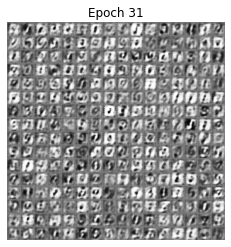

 25%|██████████▎                               | 63/256 [02:48<08:22,  2.61s/it]

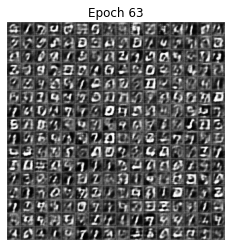

 37%|███████████████▌                          | 95/256 [04:12<07:00,  2.61s/it]

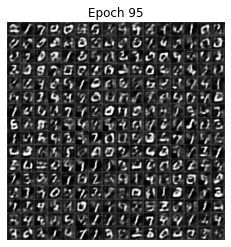

 50%|████████████████████▎                    | 127/256 [05:35<05:37,  2.62s/it]

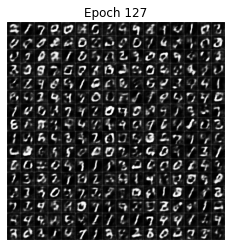

 62%|█████████████████████████▍               | 159/256 [06:59<04:13,  2.61s/it]

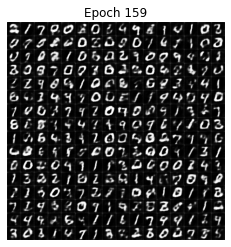

 75%|██████████████████████████████▌          | 191/256 [08:23<02:50,  2.63s/it]

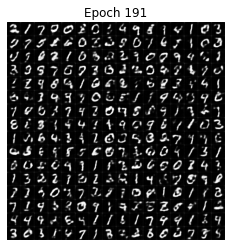

 87%|███████████████████████████████████▋     | 223/256 [09:48<01:28,  2.68s/it]

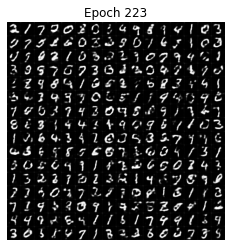

100%|████████████████████████████████████████▊| 255/256 [11:14<00:02,  2.70s/it]

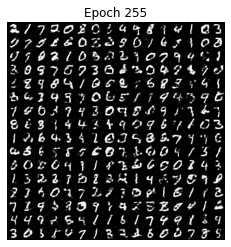

100%|█████████████████████████████████████████| 256/256 [11:16<00:00,  2.64s/it]


In [10]:
wlg = [None] * W_EPOCH #record loss of g for each epoch
wld = [None] * W_EPOCH #record loss of d for each epoch
wsp = [None] * W_EPOCH #record sample images for each epoch

rsTrain = float(BATCH_SIZE) / float(len(iTrain))
ctr = 0
for ep in tqdm(range(W_EPOCH)):
    lgt = 0.0
    ldt = 0.0
    for c1 in dsTrain:
        lg, ld = WTrain[ctr](c1)
        ctr += 1
        lgt += lg.numpy()
        ldt += ld.numpy()
        if ctr == WCritic : ctr = 0
    wlg[ep] = lgt * rsTrain
    wld[ep] = ldt * rsTrain
    
    out = WG(s, training = False)
    img = utPuzzle(
        (out * 255.0).numpy().astype(np.uint8),
        SAMPLE_COL,
        SAMPLE_ROW,
        "imgs/w_%04d.png" % ep
    )
    wsp[ep] = img
    if (ep+1) % 32 == 0:
        
        plt.imshow(img[..., 0], cmap = "gray")
        plt.axis("off")
        plt.title("Epoch %d" % ep)
        plt.show()

In [11]:
utMakeGif(np.array(wsp), "output/improved_wgan.gif", duration = 2)

MoviePy - Building file imgs/wgan.gif with imageio.


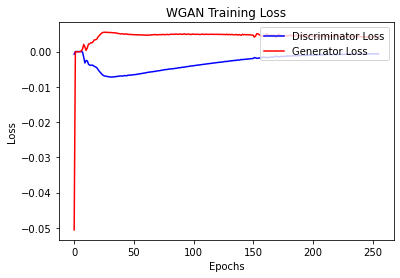

In [12]:
plt.plot(range(W_EPOCH), wld, color = "blue", label = "Discriminator Loss")
plt.plot(range(W_EPOCH), wlg, color = "red", label = "Generator Loss")
plt.legend(loc = "upper right")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("WGAN Training Loss")
plt.show()